In [103]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline


In [12]:
agg_data = pd.read_csv('train/train_agg.csv', sep='\t', index_col=None)
agg_data.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,V29,V30,USRID
0,-1.92554,-0.90689,-1.26634,0.2892,-0.68454,-1.70618,-0.29641,-0.18761,-0.48351,-0.53051,...,0.15815,-0.16201,0.4762,-0.55917,-0.77398,-0.25708,-0.27221,-0.51336,-0.32438,14233
1,-1.92554,-0.90689,-1.26634,0.2892,-0.68454,-1.70618,0.37601,-0.10030,-0.16694,-0.31897,...,0.15815,-0.16201,0.4762,-0.50058,-0.77398,-0.25708,-0.37907,-0.52723,-0.32438,790
2,-1.92554,-0.90689,-1.26634,0.2892,-0.68454,-1.57176,0.03980,-0.17089,-0.38610,-0.46000,...,0.15815,-0.16201,0.4762,-0.55127,-0.77398,-0.25708,-0.57113,-0.54758,-0.32438,82308
3,-1.92554,-0.90689,-1.26634,0.2892,-0.68454,-1.30291,-0.29641,-0.18761,-0.45916,-0.53051,...,0.15815,-0.16201,0.4762,-0.26154,-0.77398,0.23440,-0.32873,-0.51951,-0.32438,90325
4,-1.92554,-0.90689,-1.26634,0.2892,-0.68454,-1.16849,-0.29641,-0.18761,-0.50786,-0.60103,...,0.15815,-0.16201,0.4762,-0.55917,-0.77398,-0.25708,-0.57910,-0.54884,-0.32438,71893


In [33]:
log_data = pd.read_csv('train/train_log.csv', sep='\t', index_col=None)
log_data.head()

,USRID,EVT_LBL,OCC_TIM,TCH_TYP
0,10002,163-577-913,2018-03-22 16:31:44,0
1,10002,163-578-914,2018-03-22 16:31:18,0
2,10002,259-924-1525,2018-03-22 16:31:15,0
3,10002,326-1040-1677,2018-03-06 12:08:51,0
4,10002,326-1041-1678,2018-03-09 14:40:22,0


In [11]:
flag_data = pd.read_csv('train/train_flag.csv', sep='\t', index_col=None)
flag_data.head()

,USRID,FLAG
0,0,0
1,35,0
2,42,0
3,76,0
4,77,0


In [13]:
import numpy as np
import pandas as pd
from pandas import DataFrame
import xgboost as xgb
from lightgbm import LGBMClassifier
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import f1_score
import sys
import scipy as sp
from sklearn.metrics import roc_curve
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold
OFF_LINE = False


In [14]:
def xgb_model(train_set_x,train_set_y,test_set_x):
    # 模型参数
    params = {'booster': 'gbtree',
              'objective':'binary:logistic',
              'eta': 0.02,
              'max_depth': 5,  # 4 3
              'colsample_bytree': 0.7,#0.8
              'subsample': 0.7,
              'min_child_weight': 9,  # 2 3
              'silent':1
              }
    dtrain = xgb.DMatrix(train_set_x, label=train_set_y)
    dvali = xgb.DMatrix(test_set_x)
    model = xgb.train(params, dtrain, num_boost_round=800)
    predict = model.predict(dvali)
    return predict

In [15]:
def lgb_model(train_set_x,train_set_y,test_set_x):
    # 模型参数
    params = {'booster': 'gbtree',
              'objective':'binary:logistic',
              'eta': 0.02,
              'max_depth': 5,  # 4 3
              'colsample_bytree': 0.7,#0.8
              'subsample': 0.7,
              'min_child_weight': 9,  # 2 3
              'silent':1
              }
    dtrain = lgb.DMatrix(train_set_x, label=train_set_y)
    dvali = lgb.DMatrix(test_set_x)
    model = lgb.train(params, dtrain, num_boost_round=800)
    predict = model.predict(dvali)
    return predict

In [16]:
def log_tabel(data):
    EVT_LBL_len = data.groupby(by= ['USRID'], as_index = False)['EVT_LBL'].agg({'EVT_LBL_len':len})
    EVT_LBL_set_len = data.groupby(by= ['USRID'], as_index = False)['EVT_LBL'].agg({'EVT_LBL_set_len':lambda x:len(set(x))})
    
    data['hour'] = data.OCC_TIM.map(lambda x:x.hour)
    data['day'] = data.OCC_TIM.map(lambda x:x.day)
    
    return EVT_LBL_len,EVT_LBL_set_len

In [20]:
train_agg = pd.read_csv('train/train_agg.csv',sep='\t')
train_flg = pd.read_csv('train/train_flag.csv',sep='\t')
train_log = pd.read_csv('train/train_log.csv',sep='\t',parse_dates = ['OCC_TIM'])

In [21]:
train_log.head()

,USRID,EVT_LBL,OCC_TIM,TCH_TYP
0,10002,163-577-913,2018-03-22 16:31:44,0
1,10002,163-578-914,2018-03-22 16:31:18,0
2,10002,259-924-1525,2018-03-22 16:31:15,0
3,10002,326-1040-1677,2018-03-06 12:08:51,0
4,10002,326-1041-1678,2018-03-09 14:40:22,0


In [22]:
all_train = pd.merge(train_flg,train_agg,on=['USRID'],how='left')
EVT_LBL_len,EVT_LBL_set_len = log_tabel(train_log)

In [23]:
EVT_LBL_len.head()

,USRID,EVT_LBL_len
0,2,9
1,3,157
2,4,18
3,5,20
4,7,76


In [24]:
EVT_LBL_set_len.head()

,USRID,EVT_LBL_set_len
0,2,6
1,3,34
2,4,8
3,5,8
4,7,10


In [25]:
all_train = pd.merge(all_train,EVT_LBL_len,on=['USRID'],how='left')
all_train = pd.merge(all_train,EVT_LBL_set_len,on=['USRID'],how='left')
all_train.head()

,USRID,FLAG,V1,V2,V3,V4,V5,V6,V7,V8,...,V23,V24,V25,V26,V27,V28,V29,V30,EVT_LBL_len,EVT_LBL_set_len
0,0,0,0.09857,-0.90689,0.86483,0.2892,-0.68454,-0.63080,0.03980,-0.00299,...,-0.16201,-1.05667,1.06685,0.24662,-0.25708,0.78874,1.73161,1.29111,NaN,NaN
1,35,0,0.25427,1.10266,2.10801,0.2892,-0.68454,-0.63080,-0.29641,-0.18761,...,-0.16201,0.47620,-0.55917,-0.77398,-0.25708,-0.57910,-0.47456,-0.32438,33.0,13.0
2,42,0,-0.36853,-0.90689,-0.20076,0.2892,1.46083,-0.76522,-0.29641,-0.18761,...,-0.16201,-0.11429,-0.03534,-0.26368,-0.25708,0.96800,0.52019,0.88724,65.0,9.0
3,76,0,0.64353,-0.90689,-0.20076,0.2892,-0.68454,-0.22753,6.09153,0.00731,...,-0.16201,0.47620,-0.55917,-0.77398,-0.25708,-0.53975,-0.51462,-0.32438,685.0,38.0
4,77,0,-0.47233,-0.90689,-0.37835,0.2892,1.46083,-0.63080,-0.29641,-0.18761,...,-0.16201,0.14203,0.67834,0.24662,-0.25708,0.45938,-0.47425,-0.32438,NaN,NaN


In [28]:
test = pd.read_csv('test_result.csv',sep='\t')
test.head()

,USRID,target
0,92595,0
1,4572,0
2,64470,0
3,68958,0
4,8839,0


In [29]:
def log_tabel(data):
    EVT_LBL_len = data.groupby(by= ['USRID'], as_index = False)['EVT_LBL'].agg({'EVT_LBL_len':len})
    EVT_LBL_set_len = data.groupby(by= ['USRID'], as_index = False)['EVT_LBL'].agg({'EVT_LBL_set_len':lambda x:len(set(x))})
    
    data['hour'] = data.OCC_TIM.map(lambda x:x.hour)
    data['day'] = data.OCC_TIM.map(lambda x:x.day)
    
    return EVT_LBL_len,EVT_LBL_set_len

In [127]:
train_agg = pd.read_csv('./train/train_agg.csv',sep='\t')
train_flg = pd.read_csv('./train/train_flag.csv',sep='\t')
train_log = pd.read_csv('./train/train_log.csv',sep='\t',parse_dates = ['OCC_TIM'])




all_train = pd.merge(train_flg,train_agg,on=['USRID'],how='left')
EVT_LBL_len,EVT_LBL_set_len = log_tabel(train_log)

all_train = pd.merge(all_train,EVT_LBL_len,on=['USRID'],how='left')
all_train = pd.merge(all_train,EVT_LBL_set_len,on=['USRID'],how='left')
all_train.fillna(0,inplace=True)

In [109]:
# print(EVT_LBL_len[EVT_LBL_len['USRID'] == 10002])

# print(EVT_LBL_set_len[EVT_LBL_set_len['USRID'] == 10002])

      USRID  EVT_LBL_len
3874  10002          129
      USRID  EVT_LBL_set_len
3874  10002               17


In [110]:
train_log.head(20)

,USRID,EVT_LBL,OCC_TIM,TCH_TYP,hour,day,EVT_LBL_last
0,10002,163-577-913,2018-03-22 16:31:44,0,16,22,913
1,10002,163-578-914,2018-03-22 16:31:18,0,16,22,914
2,10002,259-924-1525,2018-03-22 16:31:15,0,16,22,1525
3,10002,326-1040-1677,2018-03-06 12:08:51,0,12,6,1677
4,10002,326-1041-1678,2018-03-09 14:40:22,0,14,9,1678
5,10002,326-1041-1678,2018-03-16 17:45:42,0,17,16,1678
6,10002,359-1234-2004,2018-03-15 10:40:35,0,10,15,2004
7,10002,520-1836-3640,2018-03-06 12:07:02,0,12,6,3640
8,10002,520-1836-3640,2018-03-09 11:23:01,0,11,9,3640
9,10002,520-1836-3640,2018-03-22 16:31:13,0,16,22,3640


In [105]:
def split(x):
    first = x.index('-')
    second = x.index('-', first+1)
    return x[second+1:]
    
uni = train_log
uni['EVT_LBL_last'] = train_log['EVT_LBL'].apply(split)

In [106]:
uni.head()

,USRID,EVT_LBL,OCC_TIM,TCH_TYP,hour,day,EVT_LBL_last
0,10002,163-577-913,2018-03-22 16:31:44,0,16,22,913
1,10002,163-578-914,2018-03-22 16:31:18,0,16,22,914
2,10002,259-924-1525,2018-03-22 16:31:15,0,16,22,1525
3,10002,326-1040-1677,2018-03-06 12:08:51,0,12,6,1677
4,10002,326-1041-1678,2018-03-09 14:40:22,0,14,9,1678


In [122]:
from collections import Counter
def get_max_accur(x):
    count = Counter(x)
#     print(count)
#     exit
    a = count[max(count,key=count.get)]
    return a

grouped =  uni.groupby(by=['USRID'], as_index = False)['EVT_LBL_last'].agg({'max_accur': get_max_accur})

In [123]:
grouped['max_accur']

0         3
1        37
2         7
3         6
4        26
5        28
6        11
7        25
8        44
9         3
10       16
11        7
12        5
13       12
14        6
15       12
16        7
17       63
18       15
19       28
20       13
21       15
22       12
23       30
24       11
25        1
26       14
27        6
28        3
29       81
         ..
38998     5
38999     5
39000     4
39001    23
39002     9
39003    51
39004    39
39005    12
39006    16
39007     7
39008     1
39009     9
39010     5
39011    36
39012     5
39013    18
39014    25
39015    10
39016     4
39017    85
39018     9
39019     4
39020    10
39021     2
39022    46
39023     6
39024     4
39025    12
39026    62
39027     1
Name: max_accur, Length: 39028, dtype: int64

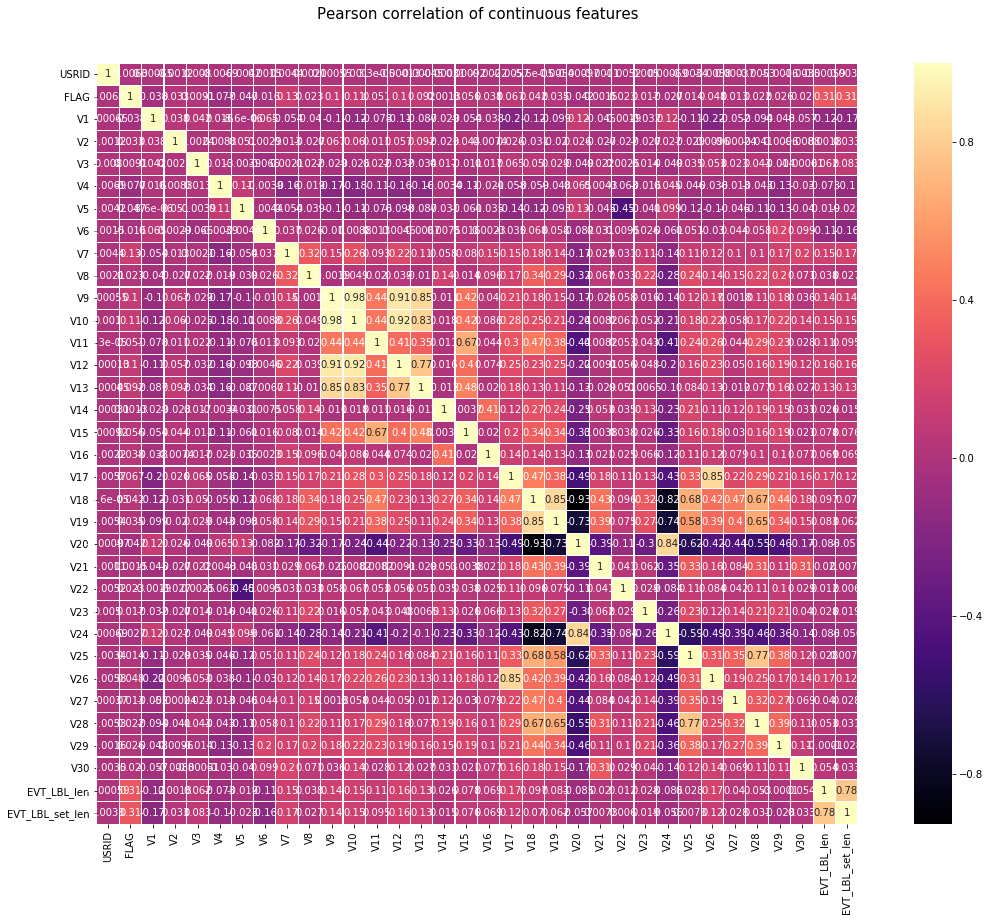

In [45]:


colormap = plt.cm.magma
plt.figure(figsize=(20,14))
plt.title('Pearson correlation of continuous features', y=1.05, size=15)
sns.heatmap(all_train.corr(),linewidths=0.1,vmax=1.0, square=True, 
            cmap=colormap, linecolor='white', annot=True)

In [64]:
def drop(data):
    data['V9_V10'] = data['V9'] * data['V10']
    col_to_drop = ['V3', 'V14', 'V21', 'V25', 'V27']
    data = data.drop(col_to_drop, axis=1)
    return data

In [128]:
all_train.shape

(80000, 34)

In [129]:
# all_train = drop(all_train)
corr = all_train.corr()
corr.FLAG

USRID              0.006329
FLAG               1.000000
V1                -0.038479
V2                 0.033167
V3                 0.009077
V4                -0.077212
V5                -0.047205
V6                -0.016155
V7                 0.131976
V8                 0.022540
V9                 0.100110
V10                0.106591
V11                0.051198
V12                0.101730
V13                0.092369
V14                0.001260
V15                0.055679
V16                0.038040
V17                0.066877
V18                0.042427
V19                0.035440
V20               -0.041894
V21                0.001485
V22                0.023474
V23                0.016918
V24               -0.027303
V25                0.014061
V26                0.048218
V27                0.013467
V28                0.021628
V29                0.026091
V30                0.019778
EVT_LBL_len        0.310435
EVT_LBL_set_len    0.312185
Name: FLAG, dtype: float64

In [124]:
col = ['V7', 'V9', 'V10', 'V12', 'EVT_LBL_len', 'EVT_LBL_set_len', 'FLAG']
sub_train = all_train[col]

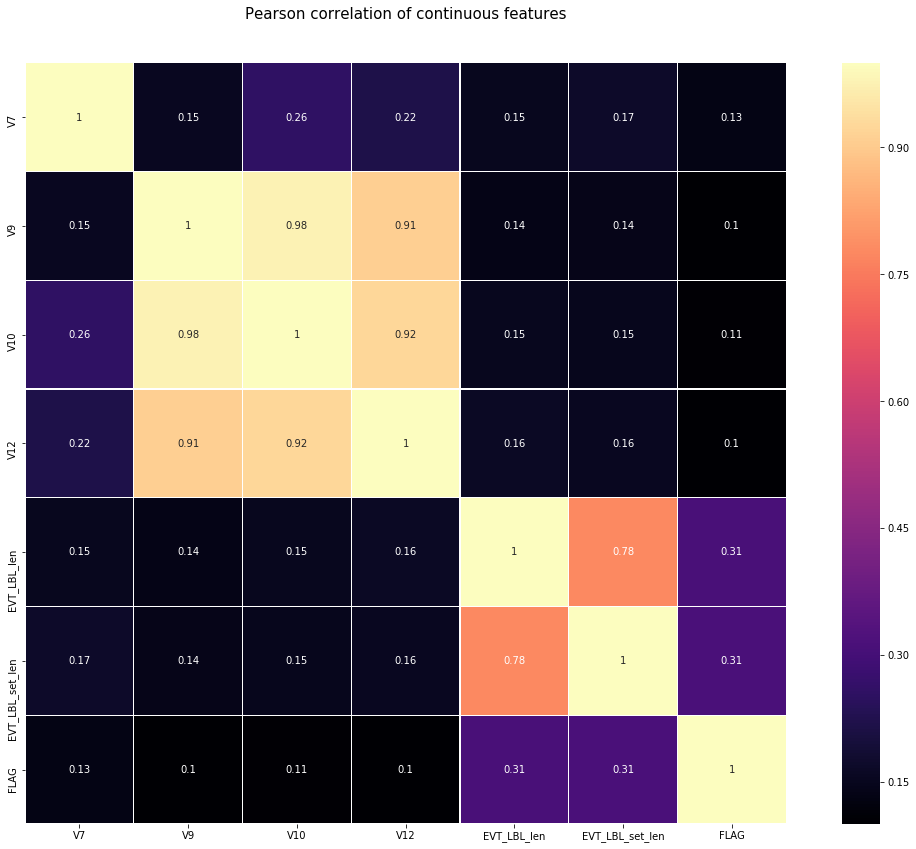

In [125]:
colormap = plt.cm.magma
plt.figure(figsize=(20,14))
plt.title('Pearson correlation of continuous features', y=1.05, size=15)
sns.heatmap(sub_train.corr(),linewidths=0.1,vmax=1.0, square=True, 
            cmap=colormap, linecolor='white', annot=True)

In [97]:
col = list(all_train.columns)
print(col)


['USRID', 'FLAG', 'V1', 'V2', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V22', 'V23', 'V24', 'V26', 'V28', 'V29', 'V30', 'EVT_LBL_len', 'EVT_LBL_set_len', 'V9_V10']


In [99]:
col.pop(0)
col.pop(0)

for i in range(len(col)):
    for j in range(i + 1, len(col)-1):
        col_name = col[i] + '_' + col[j]
#         print(col_name)
        sub_train[col_name] = all_train[col[i]] * all_train[col[j]]

c:\users\mokun\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [101]:
corr = sub_train.corr()
print(corr.FLAG[corr.FLAG > 0.1])

V7                             0.131976
V9                             0.100110
V10                            0.106591
V12                            0.101730
EVT_LBL_len                    0.310435
EVT_LBL_set_len                0.312185
FLAG                           1.000000
V7_EVT_LBL_len                 0.107449
V7_EVT_LBL_set_len             0.166742
V9_EVT_LBL_len                 0.159816
V9_EVT_LBL_set_len             0.167675
V10_EVT_LBL_len                0.167279
V10_EVT_LBL_set_len            0.176882
V12_EVT_LBL_len                0.160987
V12_EVT_LBL_set_len            0.173998
EVT_LBL_len_EVT_LBL_set_len    0.282311
V13_EVT_LBL_len                0.146278
V13_EVT_LBL_set_len            0.152994
V17_EVT_LBL_set_len            0.109081
Name: FLAG, dtype: float64


In [57]:
t0 = sub_train[sub_train.FLAG == 0]
t1 = sub_train[sub_train.FLAG == 1]
t0.describe()

,V7,V9,V10,V12,EVT_LBL_len,EVT_LBL_set_len,FLAG
count,76824.000000,76824.000000,76824.000000,76824.000000,76824.000000,76824.000000,76824.0
mean,-0.026534,-0.019782,-0.020769,-0.019309,37.563574,6.217810,0.0
std,0.894433,0.961247,0.962107,0.972889,81.028602,9.064757,0.0
min,-3.658480,-1.895880,-1.141630,-1.953140,0.000000,0.000000,0.0
25%,-0.296410,-0.507860,-0.530510,-0.534330,0.000000,0.000000,0.0
50%,-0.296410,-0.410450,-0.389490,-0.356970,0.000000,0.000000,0.0
75%,0.039800,0.003520,0.057100,-0.002270,45.000000,10.000000,0.0
max,71.651890,30.613140,27.157770,43.035110,2928.000000,115.000000,0.0


In [58]:
t1.describe()

,V7,V9,V10,V12,EVT_LBL_len,EVT_LBL_set_len,FLAG
count,3176.000000,3176.000000,3176.000000,3176.000000,3176.000000,3176.000000,3176.0
mean,0.655473,0.496005,0.528477,0.507132,204.040932,22.403338,1.0
std,2.418407,1.699035,1.678890,1.598734,301.282307,18.499886,0.0
min,-81.658500,-2.626420,-2.152320,-0.593440,0.000000,0.000000,1.0
25%,-0.296410,-0.434800,-0.412990,-0.416090,28.000000,9.000000,1.0
50%,0.039800,-0.118240,-0.060420,-0.061390,91.000000,18.000000,1.0
75%,0.712210,0.782760,0.879760,0.825370,247.000000,32.000000,1.0
max,30.298430,51.311760,48.734890,39.428960,4455.000000,148.000000,1.0


In [61]:
t0.head(10)

,V7,V9,V10,V12,EVT_LBL_len,EVT_LBL_set_len,FLAG
0,0.03980,-0.50786,-0.38949,-0.35697,0.0,0.0,0
1,-0.29641,-0.48351,-0.57752,-0.53433,33.0,13.0,0
2,-0.29641,-0.38610,-0.08393,-0.47521,65.0,9.0,0
3,6.09153,-0.02083,-0.13094,0.23420,685.0,38.0,0
4,-0.29641,-0.50786,-0.41299,-0.29786,0.0,0.0,0
5,0.03980,-0.41045,-0.38949,-0.35697,107.0,35.0,0
6,-0.29641,-0.50786,-0.60103,-0.53433,102.0,20.0,0
7,-0.29641,-0.50786,-0.48350,-0.41609,0.0,0.0,0
8,-0.29641,-0.28870,-0.36598,-0.17962,35.0,14.0,0
9,-0.29641,2.02468,2.03148,2.83536,0.0,0.0,0


In [60]:
t1.head(10)

,V7,V9,V10,V12,EVT_LBL_len,EVT_LBL_set_len,FLAG
129,-0.29641,-0.31305,-0.43649,-0.35697,0.0,0.0,1
138,-0.29641,-0.43480,-0.46000,-0.35697,471.0,28.0,1
165,-0.29641,0.80711,0.57420,0.76625,346.0,35.0,1
173,0.37601,-0.48351,0.69172,0.11596,157.0,43.0,1
183,1.38463,1.00192,0.87976,0.58890,319.0,44.0,1
242,-0.29641,0.32009,0.59770,-0.12050,851.0,27.0,1
257,0.71221,2.60911,2.40755,2.53977,26.0,9.0,1
322,2.39325,2.53606,2.76012,2.06683,7.0,6.0,1
391,1.38463,0.12528,0.01009,0.11596,356.0,24.0,1
411,0.71221,-0.36175,0.73873,0.23420,0.0,0.0,1
